# Basic Data Gathering
(state of the code after session 1)

In [ ]:
import sys
!{sys.executable} -m pip install gitpython
!{sys.executable} -m pip install pyvis

     |████████████████████████████████| 163kB 6.9MB/s 
     |████████████████████████████████| 71kB 4.1MB/s 


In [ ]:
# all the needed imports
import os
import sys
import re

import pathlib
from pathlib import Path

import networkx as nx
import matplotlib.pyplot as plt

from git import Repo

In [ ]:
cwd = os.getcwd()
print(cwd)


/content


In [ ]:
# NOTE: this must end in /
CODE_ROOT_FOLDER="/content/Zeegu-Core/"


In [ ]:
if not os.path.exists(CODE_ROOT_FOLDER):
  Repo.clone_from("https://github.com/zeeguu-ecosystem/Zeeguu-Core", CODE_ROOT_FOLDER)


In [ ]:
repo = Repo(CODE_ROOT_FOLDER)

In [ ]:
# utility functions used later

# full path to the file given a relative file_name
def file_path(file_name):
    return CODE_ROOT_FOLDER+file_name

In [ ]:
# naïve way of extracting imports
def imports(file):

    def extract_import_from_line(line):
      x = re.search("^import (\S+)", line) 
      x = re.search("^from (\S+)", line) 
      return x.group(1)

    # extracts all the imported modules from a file
    lines = [line for line in open(file)]
    
    all_imports = []
    for line in lines:
        try:
            all_imports.append(extract_import_from_line(line))
        except:
            continue

    return all_imports

assert "sqlalchemy" in imports(file_path('zeeguu_core/model/user.py'))

In [ ]:
def module_from_file_path(folder_prefix, full_path):
    # extracting a module from a file name
    # e.g. ../zeeguu_core/model/user.py -> zeeguu_core.model.user
    
    file_name = full_path[len(folder_prefix):]
    file_name = file_name.replace("/",".")
    file_name = file_name.replace(".py","")
    return file_name

def module(full_path):
    return module_from_file_path(CODE_ROOT_FOLDER, full_path)

assert 'zeeguu_core.model.user' == module(file_path('zeeguu_core/model/user.py'))

In [74]:
def dependencies_graph():
    files = Path(CODE_ROOT_FOLDER).rglob("*.py")

    G = nx.Graph()

    for file in files:

        m = module(str(file))
        if m not in G.nodes:
            G.add_node(m)

        for each in imports(str(file)):
            G.add_edge(m, each)

    return G



In [ ]:
def draw_graph(G):
    plt.figure(figsize=(10,6))
    nx.draw(G)
    plt.show()

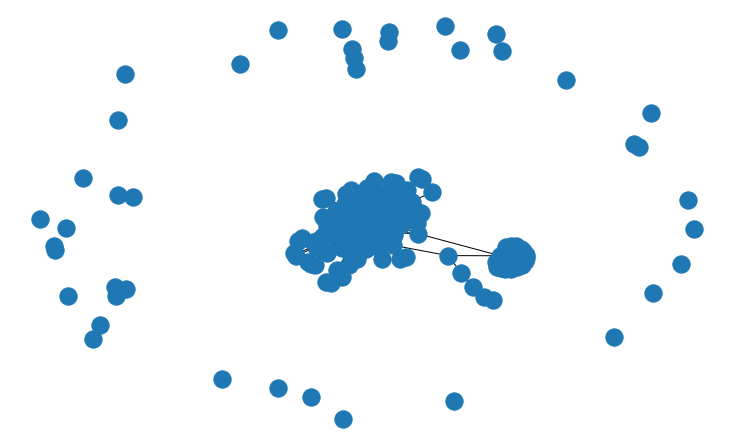

In [ ]:
G = dependencies_graph()
draw_graph(G)

# Basic Abstraction/Knowledge-Inference

## Abstracting Dependencies Between Modules

Let us abstract away the details of calls between files 
to the level of the top level modules. 

To do this we have to map every python file to a top level module.

In [66]:
"""
    Extracts the parent of depth X 
    e.g. 
      top_level_module(zeeguu_core.model.util, 1) -> zeeguu_core

"""
def top_level_module(module_name, depth=1):
    components = module_name.split(".")
    return ".".join(components[:depth])

assert (top_level_module("zeeguu_core.model.util") == "zeeguu_core")
assert (top_level_module("zeeguu_core.model.util", 2) == "zeeguu_core.model")

In [67]:
""" 
    Returns a new graph that only has top level 
    modules and dependencies between them
"""
def abstracted_to_top_level(G):
    aG = nx.Graph()
    for each in G.edges():
        # TODO: remove self-dependencies
        aG.add_edge(top_level_module(each[0]),
                    top_level_module(each[1]))
    return aG

In [68]:
def draw_graph_with_labels(G, figsize=(10,10)):
    plt.figure(figsize=figsize)
    nx.draw(G, with_labels=True)
    plt.show()

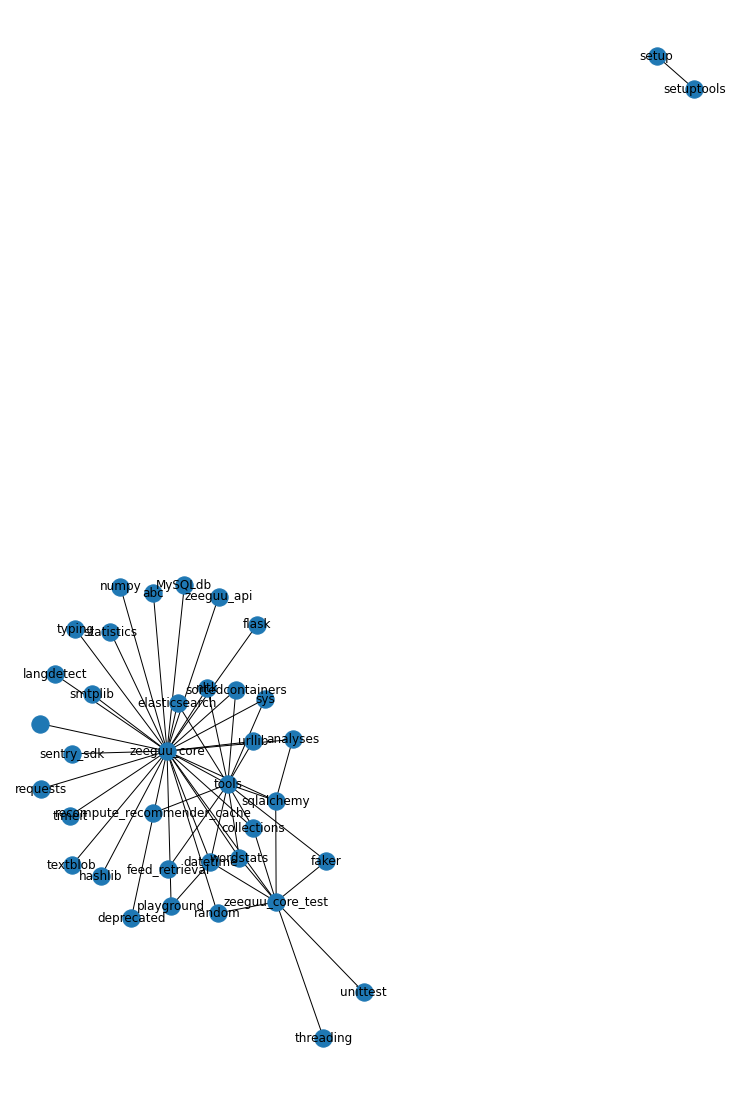

In [69]:
G = dependencies_graph()
aG = abstracted_to_top_level(G)
draw_graph_with_labels(aG, (10,15))

### Problem: We're showing too many 3rd party dependencies

Let us only add to the graph those modules that are defined in our system.
Heuristic: their name starts with zeeguu.

In [58]:
def is_system_module(m):
    return m.startswith('zeeguu')

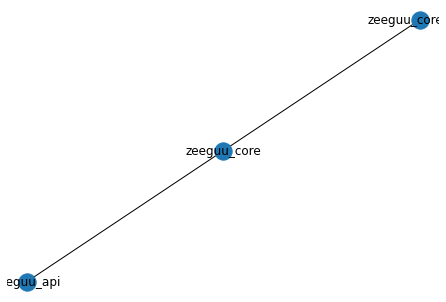

In [59]:
def abstracted_to_top_level(G):
    aG = nx.Graph()
    for each in G.edges():
        source = top_level_module(each[0])
        destination = top_level_module(each[1])
        if is_system_module(source) and is_system_module(destination):
            aG.add_edge(source, destination)
    return aG

G = dependencies_graph()
aG = abstracted_to_top_level(G)
draw_graph_with_labels(aG, (6,4))    

### Problem: Our graph edges do not have directionality.

We don't know if test depends on core, or the other way around. 
Let's start using the `DiGraph` class from `networkx`.

In [60]:
def dependencies_graph():
    files = Path(CODE_ROOT_FOLDER).rglob("*.py")

    G = nx.DiGraph()

    for file in files:
        m = module(str(file))
        if m not in G.nodes:
            G.add_node(m)

        for each in imports(str(file)):
            G.add_edge(m, each)

    return G

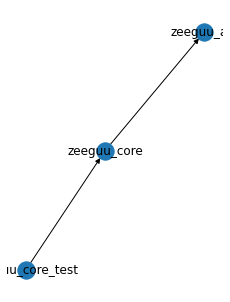

In [61]:
def abstracted_to_top_level(G):
    aG = nx.DiGraph()
    for each in G.edges():
        source = top_level_module(each[0])
        destination = top_level_module(each[1])
        if is_system_module(source) and is_system_module(destination):
            aG.add_edge(source, destination)
    return aG

directed = dependencies_graph()
directedAbstracted = abstracted_to_top_level(directed)
draw_graph_with_labels(directedAbstracted, (3,4))    

OOps!! Something unexpected.
Core should not depend on API!

### But we know that there are other Top Level Modules that do not start with zeeguu: e.g. 'tools' or 'playground'

In [62]:
# we redefine the system modules
def is_system_module(m):
    return m.startswith('zeeguu') or m=='tools' or m=='playground'

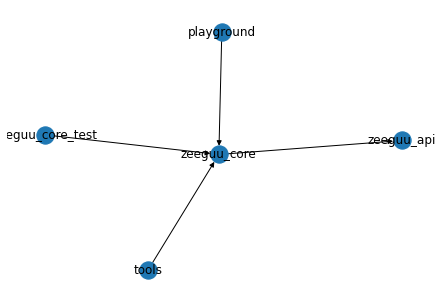

In [63]:
# then we redraw
directed = dependencies_graph()
directedAbstracted = abstracted_to_top_level(directed)
draw_graph_with_labels(directedAbstracted, (6,4))

## Abstracting Module Properties

- simplest property: size in LOC

In [64]:
# the simplest possible code metric
def LOC(file):
    return sum([1 for line in open(file)])


def module_size(m):
    size = 0
    files = Path(CODE_ROOT_FOLDER).rglob("*.py")
    for file in files:
        module_name = module(str(file))
        if module_name.startswith(m + '.'):
            size += LOC(str(file))
            
    return size

module_size("zeeguu_core")
module_size("zeeguu_core_test")
module_size("zeeguu_api")


0

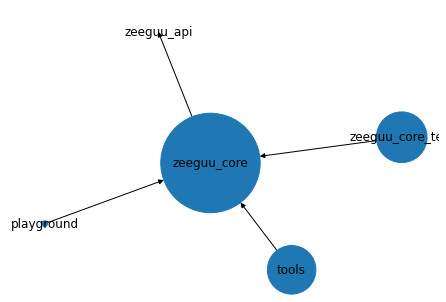

In [65]:
def draw_graph_with_weights(G, weight_function, figsize=(10,10)):
    
    node_weights = [weight_function(each) for each in G.nodes]
    
    plt.figure(figsize=figsize)
    nx.draw(G,
            with_labels=True,
            node_size=node_weights)
    plt.show()

directed = dependencies_graph()
directedAbstracted = abstracted_to_top_level(directed)
draw_graph_with_weights(directedAbstracted, module_size, (6,4))    